In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) 

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from FusedEmbedding import FusedEmbedding, Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [4]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score

In [5]:
# from rdkit.Chem import rdMolDescriptors, MolSurf
# from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

In [6]:
task_name = 'Multi-Targeting'
tasks = []

Dataset_ChEMBL22_BioMedX = pd.read_csv("../data/Dataset_ChEMBL22_BioMedX.csv")
Dataset_Christmann2016 = pd.read_csv("../data/Dataset_Christmann2016.csv")
Dataset_PKIS = pd.read_csv("../data/Dataset_PKIS.csv")
Dataset_Tang = pd.read_csv("../data/Dataset_Tang.csv")


In [7]:
merged = pd.concat([Dataset_ChEMBL22_BioMedX, Dataset_Christmann2016, Dataset_PKIS, Dataset_Tang], sort=False, ignore_index=True, axis=0) 

number of all smiles:  49847
number of successfully processed smiles:  49847


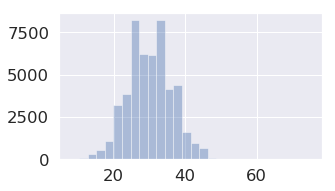

In [8]:
smilesList = merged.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
merged = merged[merged["smiles"].isin(remained_smiles)]
merged['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

In [140]:
merged_df = merged.groupby('cano_smiles', sort=False).mean().reset_index()
merged_df['smiles'] = merged.smiles.groupby(merged.cano_smiles, sort=False)\
                            .apply(lambda x: ','.join(x.astype(str).values))\
                            .reset_index().smiles

In [141]:
# merged_df = merged.groupby('cano_smiles')\
#         .apply(lambda x: '' if x.isnull().any() else x.values.mean())
# merged_df = merged.groupby('cano_smiles').agg({'EphA5': 'sum', 'EphA8': 'mean'})

In [142]:
merged_df1 = merged_df.drop(merged_df.filter(like='_b', axis=1).columns, axis=1)

In [143]:
merged_df1['count'] = merged_df1.count(axis=1).values
merged_df1.sort_values(['count'], ascending=False)

,cano_smiles,EphA5,EphA8,EphB1,ATR,EphB2,EphB3,EphB4,EphB6,ABL1,...,RIPK3,ANKRD3,CRIK,NEK10,DAPK2,ULK3,SNRK,RSK4,smiles,count
311,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,5.575172,5.995220,5.323019,NaN,5.563651,4.779138,5.798483,6.589617,6.811528,...,NaN,4.450730,5.083058,NaN,4.588048,4.505657,4.176096,NaN,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,392
24918,N#Cc1c(NC(=O)c2cccc3ccccc23)sc2c1CCCC2,4.176096,4.247103,4.364239,NaN,4.810417,4.682948,4.696756,4.246672,4.588048,...,NaN,4.176096,4.176096,NaN,4.351225,4.176096,4.176096,5.0000,"N#Cc1c(NC(=O)c2cccc3ccccc23)sc2c1CCCC2,N#Cc1c(...",390
178,CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2...,7.272695,6.608681,6.980653,NaN,6.282722,5.298206,6.359977,5.838890,6.937265,...,5.0,6.958607,6.468521,NaN,8.455002,8.223265,7.045757,NaN,CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2...,390
47652,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(F)c...,5.366968,4.898427,6.276999,NaN,5.603973,4.919307,5.500724,6.035291,6.372578,...,NaN,5.677781,5.257809,NaN,6.699907,6.970798,6.193820,NaN,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(F)c...,384
14320,COc1cc2ncn(-c3cc(OCc4ccccc4C(F)(F)F)c(C(N)=O)s...,4.176096,4.545742,4.176096,NaN,4.588048,4.749699,4.588048,5.959090,5.322640,...,NaN,4.176096,5.212608,NaN,5.249877,4.475237,4.311371,5.4903,COc1cc2ncn(-c3cc(OCc4ccccc4C(F)(F)F)c(C(N)=O)s...,378
25878,Cn1c2ccccc2c2c3c(c4c5ccccc5n(CCC#N)c4c21)CNC3=O,4.914669,5.078292,5.088826,NaN,4.966952,4.842303,4.557451,6.301030,5.758668,...,NaN,7.561835,6.589095,NaN,5.182180,6.322927,5.953543,NaN,Cn1c2ccccc2c2c3c(c4c5ccccc5n(CCC#N)c4c21)CNC3=...,378
6885,COc1cc2ncnc(Nc3cccc(Cl)c3)c2cc1OC,5.446787,5.346360,5.273001,NaN,4.641817,4.357186,5.927389,5.720159,6.306939,...,NaN,5.122406,6.097379,4.176096,4.843032,4.967356,4.611140,NaN,"COc1cc2ncnc(Nc3cccc(Cl)c3)c2cc1OC,COc1cc2ncnc(...",376
46074,N#CC(=C1Nc2ccccc2S1)c1ccnc(NCCc2cccnc2)n1,4.176096,4.319871,4.641899,NaN,4.176096,4.548740,4.627514,6.480725,4.450136,...,NaN,6.060698,4.841932,NaN,4.888191,4.838266,6.556749,NaN,"N#CC(=C1Nc2ccccc2S1)c1ccnc(NCCc2cccnc2)n1,N#CC...",375
46199,O=C1Nc2ccc(I)cc2C1=Cc1cc(Br)c(O)c(Br)c1,4.176096,4.176096,4.176096,NaN,4.588048,4.588048,4.588048,5.500602,4.887559,...,NaN,4.499398,6.226784,NaN,6.712915,5.865301,4.176096,5.0000,"O=C1Nc2ccc(I)cc2C1=Cc1cc(Br)c(O)c(Br)c1,O=C1Nc...",373
47655,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,4.794024,4.962736,4.961142,NaN,4.898582,5.191999,5.002214,5.886057,5.067609,...,NaN,5.000000,5.000000,NaN,4.794024,4.725365,NaN,NaN,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,373


In [224]:
kinase_ids = pd.read_csv('../data/kinase_ids.csv')
mapped_id = {}

for kinase in merged_df1.columns:
    for names in kinase_ids['Gene names']: 
        if kinase.upper() in names.split(' '):
            mapped_id[kinase] = names.split(' ')[0]
#     if kinase not in mapped_id.keys():
#         print(kinase)

In [225]:
mapped_id['PDK1'] = 'PDPK1'
mapped_id['PAK5'] = 'PAK5'
mapped_id['NIK'] ='MAP3K14'

In [238]:
for protein, gene in mapped_id.items():
    if gene == 'MAP3K7':
        print(protein)

MAP3K7
TAK1


In [227]:
kinase_ids_unmatched = pd.read_csv('../data/kinase_ids_unmatched.csv',header=None)
kinase_ids_unmatched_dict = dict(zip(kinase_ids_unmatched[0], kinase_ids_unmatched[1]))
    
merged_df1.rename(columns=mapped_id, inplace=True)
merged_df1.rename(columns=kinase_ids_unmatched_dict, inplace=True)

In [228]:
merged_df1['TAK1'] = merged_df1['MAP3K7'].apply(lambda x: x.mean(), axis=1)

In [229]:
merged_df2 = merged_df1.drop(columns=['smiles', 'count', 'MAP3K7'])
merged_df2.rename(columns={'TAK1':'MAP3K7'}, inplace=True)

/home/pytorch/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [ ]:
gene_name = ['BRAF','MAPK15','MKNK1','PDPK1','RET','RPS6KB1','SRC','TTK','AURKA','AURKB','AURKC',\
             'FGFR1','FGFR2','FGFR3','FGFR4','STK11','PAK1','PAK2','PAK3','PAK4','PAK5','PAK6','PIK3CA','MAP3K7']
row_name =  ['BRAF','ERK8','MKNK1','PDPK1','RET','S6K','SRC','TTK','AURKA','AURKB','AURKC',\
             'FGFR1','FGFR2','FGFR3','FGFR4','LKB1','PAK1','PAK2','PAK3','PAK4','PAK5','PAK6','PIK3CA','TAK1']

In [211]:
task1_df = merged_df2[['RET','BRAF','SRC','RPS6KB1','MKNK1','TTK','MAPK15','PDPK1','PAK3','cano_smiles']].dropna().reset_index()

In [232]:
task2_df = merged_df2[['AURKA','PAK1','FGFR1','STK11','PAK3','MAP3K7','cano_smiles']].dropna(thresh=1).reset_index() # 'PIK3CA' has no data

In [234]:
task2_df.loc[task2_df['cano_smiles']=='O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23']

,index,AURKA,PAK1,FGFR1,STK11,PAK3,MAP3K7,cano_smiles
47937,47937,5.605548,NaN,NaN,NaN,NaN,NaN,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23


In [150]:
merged_df3 = merged_df2.melt(id_vars=['cano_smiles']).dropna().reset_index().drop(columns = ['index'])

In [186]:
merged_df4 = merged_df3.groupby('cano_smiles').filter(lambda x: len(x) > 19)
merged_df4 = merged_df4.groupby('variable').filter(lambda x: len(x) > 19).reset_index()
# merged_df4.to_csv('../data/smiles_kinase_activity.csv',index=False)

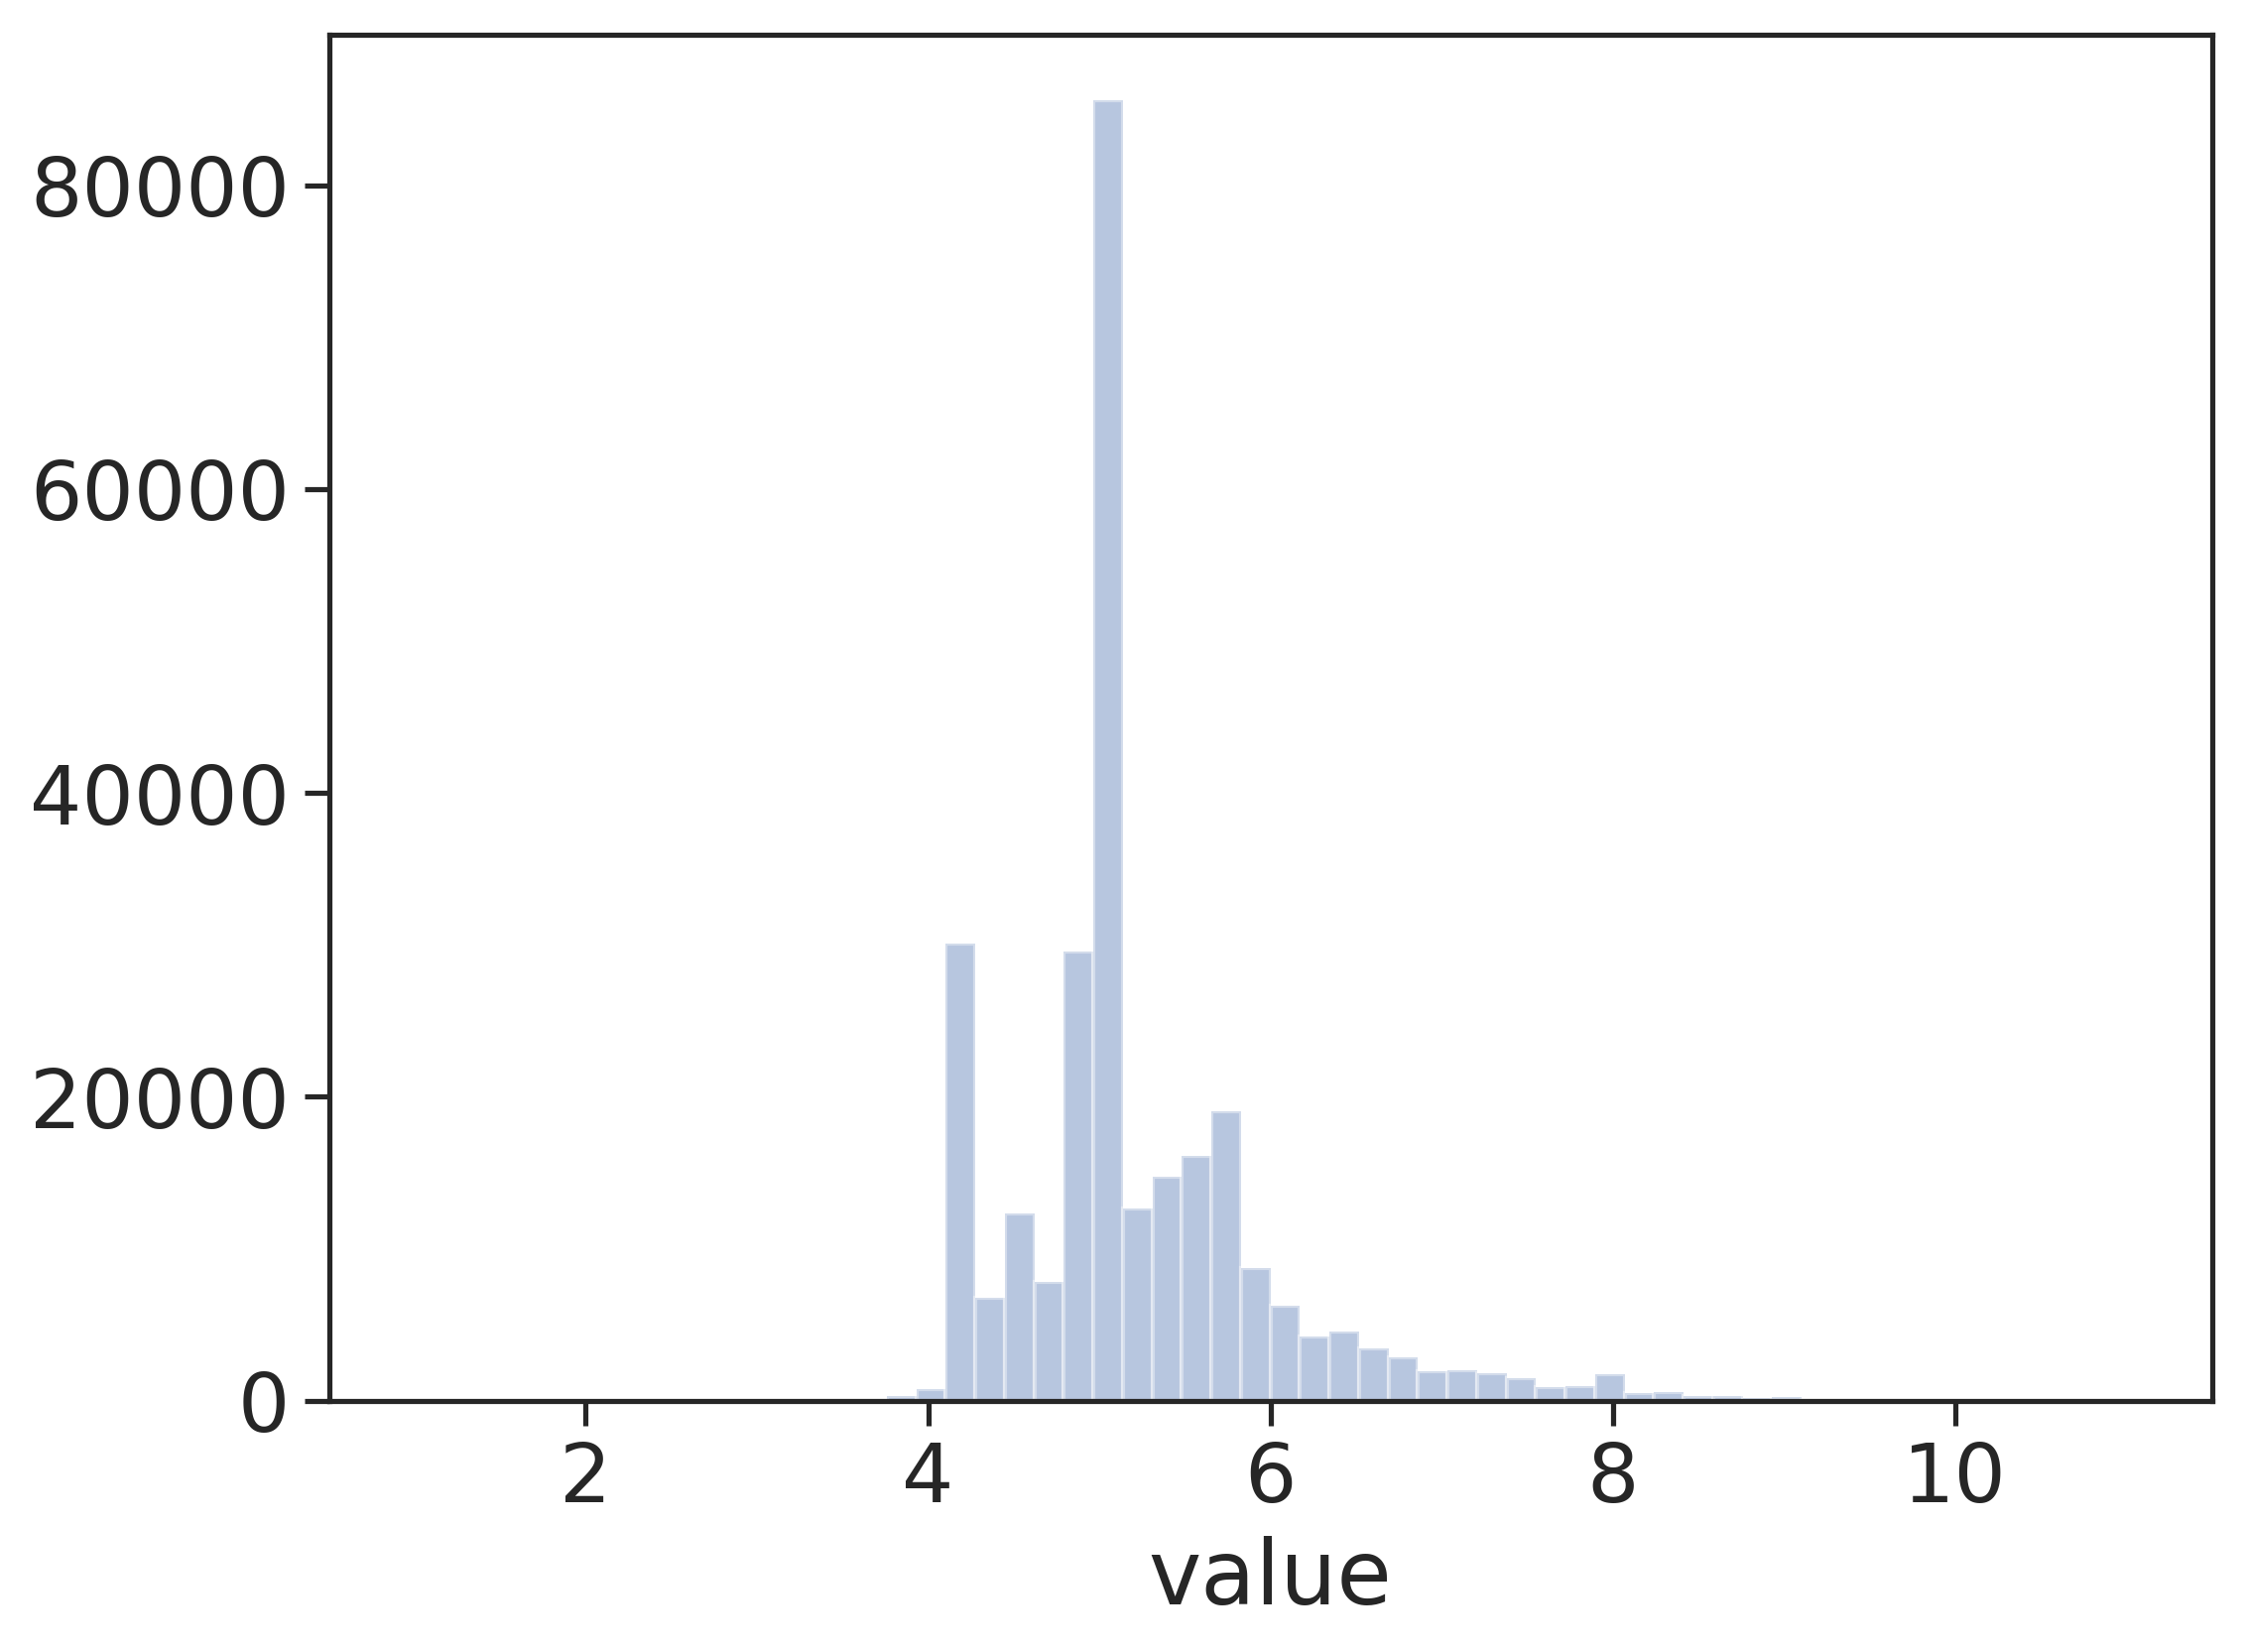

In [258]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(8,6))
sns.set(font_scale=1.8)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
ax = sns.distplot(merged_df4.value, bins=58, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=300)
plt.show()
plt.close()

In [130]:
# merged_df4.value = merged_df4.value.apply(lambda x: np.where(x <= 5,0,1))
# merged_df4.value = merged_df4.value.apply(lambda x: np.where(x > 5 and x <6,1,x))
# merged_df4.value = merged_df4.value.apply(lambda x: np.where(x >= 6,2,x))

In [260]:
merged_df5 = merged_df4.copy()
merged_df5.value = merged_df5.value.apply(lambda x: np.where(x < 5,0,x))
merged_df5.value = merged_df5.value.apply(lambda x: np.where(x >= 5 and x <6,1,x))
merged_df5.value = merged_df5.value.apply(lambda x: np.where(x >= 6,2,x))
merged_df5['value'].value_counts()

1.0    155404
0.0     89173
2.0     34524
Name: value, dtype: int64

In [242]:
len(merged_df5)

279101

In [200]:
merged_df5 = merged_df5.drop(columns=['index'])
merged_df5.rename(columns={'cano_smiles': 'smiles', 'variable':'kinase', 'value':'class'}, inplace=True)
merged_df5.to_csv('../data/smiles_kinase_class.csv',index=False)